In [82]:
from detection_UVW import *

In [83]:
from diffusion_training_UVW import *

In [84]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [85]:
import torch.nn.functional as F

In [86]:
def load_parameters(device, argN = None):
    """
    Loads the trained parameters for the detection model
    :return:
    """
    import sys
    if argN is not None:
        print(f"Loading from {argN} Number")
#         params = os.listdir("./model")
        # Use a list comprehension to find the matching string
        params = [f'{argN}'] # [s for s in params if f'={argN}' in s]

    elif len(sys.argv[1:]) > 0:
        params = sys.argv[1:]
    else:
        params = os.listdir("./model")
    if ".DS_Store" in params:
        params.remove(".DS_Store")

    if params[0] == "CHECKPOINT":
        use_checkpoint = True
        params = params[1:]
    else:
        use_checkpoint = False
#     use_checkpoint = True
#     print(params)
    for param in params:
        if param.isnumeric():
            output = load_checkpoint(param, use_checkpoint, device)
        elif param[:4] == "args" and param[-5:] == ".json":
            output = load_checkpoint(param[4:-5], use_checkpoint, device)
        elif param[:4] == "args":
            output = load_checkpoint(param[4:], use_checkpoint, device)
        elif  isinstance(param, str):
            output = load_checkpoint(param, use_checkpoint, device)
        else:
            raise ValueError(f"Unsupported input {param}")

        if "args" in output:
            args = output["args"]
        else:
            try:
                with open(f'./test_args/args{param[17:]}.json', 'r') as f:
                    args = json.load(f)
                args['arg_num'] = param[17:]
                args = defaultdict_from_json(args)
            except FileNotFoundError:
                raise ValueError(f"args{param[17:]} doesn't exist for {param}")

        if "noise_fn" not in args:
            args["noise_fn"] = "gauss"

        return args, output

In [87]:
argN = 102

In [88]:
# os.listdir("./model")

In [89]:
args, output = load_parameters(device, argN= argN)

Loading from 102 Number


In [90]:
args.update({"Batch_Size": 32})

In [91]:

#     args.update({"octave": 8})
#     args.update({ "frequency": 64})    
#     args.update({"persistence": 0.8})
# args.update({"Batch_Size": 1})
# args.update({"noise_fn": "gauss"})
#     args.update({"cls_cond": None})
#     print(args["Batch_Size"])
print(f"args{args}")
print(args['channels'])
if args['model_name'] == "CUViT":
        model = CUViT(img_size = args['img_size'][0], patch_size=4, in_chans=args["channels"], embed_dim = args['base_channels'],
                      depth=12, num_heads=args["num_heads"], mlp_ratio=4., qkv_bias=False, qk_scale=None, norm_layer=nn.LayerNorm, 
                      mlp_time_embed=False, num_classes=args["cls_cond"],
                      use_checkpoint=False, conv=True, skip=True)
elif args['model_name'] == "UViT":
    model = UViT(img_size = args['img_size'][0], patch_size=16, in_chans=args["channels"], embed_dim = args['embed_dim'],
                 depth=12, num_heads=args["num_heads"], mlp_ratio=4., qkv_bias=False, qk_scale=None, norm_layer=nn.LayerNorm, 
                 mlp_time_embed=False, num_classes=args["cls_cond"],
                 use_checkpoint=False, conv=True, skip=True)
elif args['model_name'] == "UDHVT":
    model = UDHVT(img_size = args['img_size'][0],
                  patch_size=args["patch_size"], 
                  in_chans=args["channels"],
                  embed_dim = args['embed_dim'],     
                  depth=12, 
                  num_heads=args["num_heads"],
                  mlp_ratio=args["mlp_ratio"], 
                  qkv_bias=False, 
                  qk_scale=None, 
                  norm_layer=nn.LayerNorm,
                  mlp_time_embed=True,
                  use_checkpoint=False,
                  num_classes=args["cls_cond"],
                  conv=True, 
                  refinement=args["refinement"],
                  skip=True, 
                  deconvpatch = False, 
                  use_dec = args["mlps"],
                  PE_type = args["patch_emb"])
elif args['model_name'] == "DHUNet":
    model = DHUNet(img_size = args['img_size'][0],
                  patch_size=args["patch_size"], 
                  in_chans=args["channels"],
                  embed_dim = args['embed_dim'],     
                  depth=args['depth'], 
                  num_heads=args["num_heads"],
                  mlp_ratio=args["mlp_ratio"], 
                  qkv_bias=False, 
                  qk_scale=None, 
                  norm_layer=nn.LayerNorm,
                  mlp_time_embed=True,
                  num_classes=args["cls_cond"],
                  conv=True, skip=True)
elif args['model_name'] == "UNetModel":
    model = UNetModel(
            args['img_size'][0], args['base_channels'], channel_mults=args['channel_mults'], dropout=args[
                "dropout"], n_heads=args["num_heads"], n_head_channels=args["num_head_channels"],
            in_channels=args["channels"]
            )
else:
    model = UViT(img_size = args['img_size'][0], patch_size=16, in_chans=args["channels"], embed_dim = 128,
                 depth=12, num_heads=args["num_heads"], mlp_ratio=4., qkv_bias=False, qk_scale=None, norm_layer=nn.LayerNorm, 
                 mlp_time_embed=False, num_classes=args["cls_cond"],
                 use_checkpoint=False, conv=True, skip=True)
betas = get_beta_schedule(args['T'], args['beta_schedule'])
#     diff = GaussianDiffusionModel(
#             args['img_size'], betas, loss_weight=args['loss_weight'],
#             loss_type=args['loss-type'], noise=args["noise_fn"], img_channels=args["channels"]
#             )
diff = GaussianDiffusionModel(
    args['img_size'],
    betas, 
    loss_weight = args['loss_weight'],
    loss_type = args['loss-type'],
    noise = args["noise_fn"],
    octave = args["octave"],
    frequency = args["frequency"],
    persistence = args["persistence"],
    patch_size = args["patch_size"],
    sigma = args["sigma"],
    img_channels = args["channels"]
)    

model.load_state_dict(output["ema"])
model.to(device)
model.eval()
ema = model

argsdefaultdict(<class 'str'>, {'img_size': [256, 256], 'Batch_Size': 32, 'EPOCHS': 3000, 'T': 1000, 'base_channels': 128, 'channels': 1, 'beta_schedule': 'cosine', 'channel_mults': '', 'loss-type': 'hybrid_ms_ssim', 'loss_weight': 'none', 'train_start': True, 'lr': 0.0001, 'random_slice': False, 'sample_distance': 800, 'weight_decay': 0.0, 'save_imgs': True, 'save_vids': False, 'val_anno': False, 'model_name': 'UDHVT', 'refinement': False, 'mlps': ['MLP', 'MLP', 'MLP'], 'patch_size': 16, 'embed_dim': 768, 'depth': 12, 'num_heads': 12, 'mlp_ratio': 4, 'dropout': 0, 'attention_resolutions': '32,16,8', 'num_head_channels': -1, 'cls_cond': None, 'dir': 'DATASETS/brainMRI', 'noise_fn': '4dsimplex', 'octave': 6, 'frequency': 64, 'persistence': 0.9, 'dataset': 'brainMRI', 'arg_num': '102', 'patch_emb': '', 'sigma': ''})
1


In [11]:
_, ano_dataset = dataset.init_datasets(ROOT_DIR, args)
loader = dataset.init_dataset_loader(ano_dataset, args)

In [12]:
new = next(loader)
#         print(new["image"].shape)
img = new["image"].to(device)
img = img.reshape(args["Batch_Size"], args["channels"], *args["img_size"])
print(new["mask"].shape)
#         img_mask = new["mask"].reshape(args["Batch_Size"], -1, *args["img_size"])
if args["cls_cond"] is not None:
    lab = new["label"]
    lab = lab.to(device)
else:
    lab = args["cls_cond"]
#         lab = lab.to(device)
img_mask = transforms.Resize(args['img_size'], antialias=True)(new["mask"])
img_mask = img_mask.reshape(args["Batch_Size"], -1, *args["img_size"])
print(img_mask.shape)
#         img_mask = dataset.load_image_mask(new['filenames'][0][-9:-4], args['img_size'], ano_dataset)
img_mask = img_mask.to(device)
new['filenames']

torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])


['Y12.png',
 'Y8.png',
 'Y53.png',
 'Y246.png',
 'Y99.png',
 'Y66.png',
 'Y82.png',
 'Y4.png',
 'Y182.png',
 'Y120.png',
 'Y92.png',
 'Y71.png',
 'Y38.png',
 'Y23.png',
 'Y247.png',
 'Y32.png',
 'Y49.png',
 'Y256.png',
 'Y249.png',
 'Y259.png',
 'Y109.png',
 'Y14.png',
 'Y44.png',
 'Y95.png',
 'Y107.png',
 'Y161.png',
 'Y19.png',
 'Y78.png',
 'Y69.png',
 'Y243.png',
 'Y59.png',
 'Y45.png']

In [13]:
img1 = img
img_mask1 = img_mask

In [14]:
# fig, ax = plt.subplots()
# plt.rcParams['figure.dpi'] = 200

In [15]:

# out = diff.forward_backward(ema, img, lab, None, 800, denoise_fn="noise_fn")

In [16]:
img_mask1 = img_mask.int()

In [17]:
# plt.imshow(image_array)

In [92]:
timestep = 150
img_mask = img_mask.to(device)
output = diff.forward_backward(
    model,
    img1.reshape(args["Batch_Size"], args["channels"], *args["img_size"]),
    lab,
    see_whole_sequence=None,
    t_distance=timestep, denoise_fn = args["noise_fn"]
)

output_name = f'./diffusion-videos/ARGS={args["arg_num"]}/Anomalous/' \
              f'{new["filenames"][0]}/Qualitity_{timestep}'
output_directory = os.path.dirname(output_name)
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

mse = (img1 - output)**2

In [93]:
mae = (img1 - output).abs()

In [94]:
import numpy as np

def calculate_ece(predicted_probabilities, ground_truth_segmentation, num_bins=10):
    # Define the bin limits
    bin_limits = np.linspace(0, 1, num_bins + 1)

    # Initialize variables to track ECE components
    ece = 0.0
    total_samples = 0

    # Calculate ECE
    for bin_idx in range(num_bins):
        bin_lower, bin_upper = bin_limits[bin_idx], bin_limits[bin_idx + 1]

        # Mask for pixels falling in the current probability bin
        bin_mask = (predicted_probabilities >= bin_lower) & (predicted_probabilities < bin_upper)

        # Calculate the number of pixels in this bin
        bin_samples = np.sum(bin_mask)

        if bin_samples > 0:
            # Calculate the proportion of correctly predicted pixels in this bin
            bin_accuracy = np.mean(ground_truth_segmentation[bin_mask])

            # Calculate the average confidence in this bin
            bin_confidence = np.mean(predicted_probabilities[bin_mask])

            # Update the ECE with the contribution from this bin
            ece += bin_samples * np.abs(bin_accuracy - bin_confidence)
            total_samples += bin_samples

    if total_samples > 0:
        # Normalize ECE
        ece /= total_samples

    return ece

In [100]:
calculate_ece(mae.cpu().numpy(), img_mask.cpu().numpy(), num_bins=1000)

0.03356862867209642

In [99]:
calculate_ece(mse.cpu().numpy(), img_mask.cpu().numpy(), num_bins=1000)

0.07165749395956666

In [121]:
pred = F.softmax(mse, dim=0)

In [123]:
pred.max()

tensor(1., device='cuda:0')

In [13]:
import torch
import numpy as np
import imageio
import os

scale_img = lambda img: ((img + 1) * 127.5).clamp(0, 255).to(torch.uint8)
# Assuming 'tensor_list' contains a list of PyTorch tensors
# Replace this with your actual list of tensors

# Directory to save individual image files
output_dir = f'{ROOT_DIR}diffusion-videos/ARGS={args["arg_num"]}/{new["filenames"]}/'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Convert and save each tensor as an image
for idx, tensor in enumerate(out):
    # Convert the PyTorch tensor to a NumPy array
    tensor = scale_img(tensor)
    tensor = tensor.squeeze()
    image_array = tensor.permute(0, 2, 1).cpu().contiguous().permute(2, 1, 0)
    
    
    if idx%50==0 or idx==0:
        # Define the filename for the image (e.g., frame_0001.png)
        filename = os.path.join(output_dir, f'frame_{idx:04d}.png')

        # Save the NumPy array as an image file (you can use other formats like PNG)
        imageio.imwrite(filename, image_array, format='png')

# # Create a list of image file paths
# image_files = [os.path.join(output_dir, f'frame_{idx:04d}.png') for idx in range(len(out))]

# # Create a GIF from the saved images
# output_gif = f'{ROOT_DIR}diffusion-videos/ARGS={args["arg_num"]}/image_frames/output.gif'
# imageio.mimsave(output_gif, [imageio.imread(file) for file in image_files], duration=0.1)

# # Remove the individual image files if needed
# # for file in image_files:
# #     os.remove(file)

# print(f'GIF saved as {output_gif}')


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

In [19]:
imgs = [[ax.imshow(gridify_output(img, 2), animated=True)] for x in out]

In [20]:
len(imgs)

601

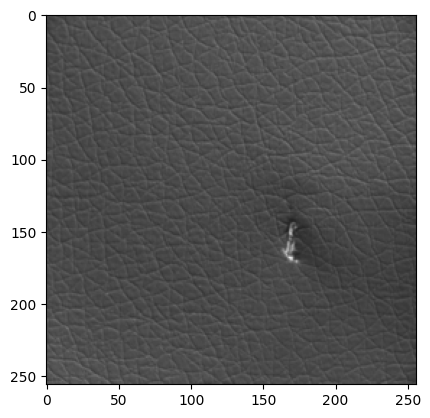

In [26]:
imgs[-1][0].figure

In [ ]:
ani = animation.ArtistAnimation(
        fig, imgs, interval=50, blit=True,
        repeat_delay=1000
        )

ani.save(f'{ROOT_DIR}diffusion-videos/ARGS={args["arg_num"]}/Anno_sample.gif')

plt.close('all')

In [ ]:
len(imgs)

In [ ]:
# imgs[-1][0].figure

In [ ]:
# imgs[0][0].figure

In [ ]:
# imgs[500][0].figure

In [ ]:
out[0].shape

In [ ]:
# import matplotlib.pyplot as plt
# import torch

# # Assuming 'image_tensor' contains the tensor with size torch.Size([1, 1, 256, 256])
# # Replace this with your actual tensor

# # Convert the PyTorch tensor to a NumPy array
# image_array = out[0].squeeze().cpu().numpy()  # Squeeze removes single-dimension entries

# # Plot the NumPy array as an image using Matplotlib
# plt.imshow(image_array, cmap='gray')  # Use 'cmap' for grayscale images
# plt.axis('off')  # Turn off axis labels
# plt.show()


In [31]:
# import matplotlib.pyplot as plt
# import torch

# # Assuming 'image_tensor' contains the tensor with size torch.Size([1, 1, 256, 256])
# # Replace this with your actual tensor

# # Convert the PyTorch tensor to a NumPy array
# image_array = out[-1].squeeze().cpu().numpy()  # Squeeze removes single-dimension entries

# # Plot the NumPy array as an image using Matplotlib
# plt.imshow(image_array, cmap='gray')  # Use 'cmap' for grayscale images
# plt.axis('off')  # Turn off axis labels
# plt.show()


In [ ]:
t_range = np.linspace(100, 800, 5).astype(np.int32)

In [ ]:
t_range

In [31]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    
    def _init_(self,ch_in,ch_out):
        super(conv_block,self)._init_()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):

    def _init_(self,ch_in,ch_out):
        super(up_conv,self)._init_()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class Recurrent_block(nn.Module):

    def _init_(self,ch_out,t=2):
        super(Recurrent_block,self)._init_()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)
            
            x1 = self.conv(x+x1)
        return x1
        
class RRCNN_block(nn.Module):

    def _init_(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self)._init_()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1	#residual learning

class RCNN_block(nn.Module):

    def _init_(self,ch_in,ch_out,t=2):
        super(RCNN_block,self)._init_()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x = self.RCNN(x)
        return x 
        
class ResCNN_block(nn.Module):

    def _init_(self,ch_in,ch_out):
        super(ResCNN_block,self)._init_()
        self.Conv = conv_block(ch_in, ch_out)
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x1 = self.Conv_1x1(x)
        x = self.Conv(x)
        return x+x1 

class U_Net(nn.Module):

    def _init_(self,img_ch=3,output_ch=1):
        super(U_Net,self)._init_()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1


class R2U_Net(nn.Module):

    def _init_(self,img_ch=3,output_ch=1,t=2):
        super(R2U_Net,self)._init_()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)
        
        self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)
        
        self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)
        
        self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)
        

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)
        
        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_RRCNN5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

class RecU_Net(nn.Module):

    def _init_(self,img_ch=3,output_ch=1,t=2):
        super(RecU_Net,self)._init_()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RCNN1 = RCNN_block(ch_in=img_ch,ch_out=64,t=t)

        self.RCNN2 = RCNN_block(ch_in=64,ch_out=128,t=t)
        
        self.RCNN3 = RCNN_block(ch_in=128,ch_out=256,t=t)
        
        self.RCNN4 = RCNN_block(ch_in=256,ch_out=512,t=t)
        
        self.RCNN5 = RCNN_block(ch_in=512,ch_out=1024,t=t)
        

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_RCNN5 = RCNN_block(ch_in=1024, ch_out=512,t=t)
        
        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_RCNN4 = RCNN_block(ch_in=512, ch_out=256,t=t)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_RCNN3 = RCNN_block(ch_in=256, ch_out=128,t=t)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_RCNN2 = RCNN_block(ch_in=128, ch_out=64,t=t)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.RCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RCNN2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.RCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_RCNN5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_RCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_RCNN3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_RCNN2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

class ResU_Net(nn.Module):

    def _init_(self,img_ch=3,output_ch=1):
        super(ResU_Net,self)._init_()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.ResCNN1 = ResCNN_block(ch_in=img_ch,ch_out=64)

        self.ResCNN2 = ResCNN_block(ch_in=64,ch_out=128)
        
        self.ResCNN3 = ResCNN_block(ch_in=128,ch_out=256)
        
        self.ResCNN4 = ResCNN_block(ch_in=256,ch_out=512)
        
        self.ResCNN5 = ResCNN_block(ch_in=512,ch_out=1024)
        

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_ResCNN5 = ResCNN_block(ch_in=1024, ch_out=512)
        
        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_ResCNN4 = ResCNN_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_ResCNN3 = ResCNN_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_ResCNN2 = ResCNN_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.ResCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.ResCNN2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.ResCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.ResCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.ResCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_ResCNN5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_ResCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_ResCNN3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_ResCNN2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

In [34]:
model = R2U_Net()

In [38]:
model.named_parameters


<bound method Module.named_parameters of R2U_Net()>